In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [2]:
# read CSV file
file_path = './SMM_preprocessed.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)
# Define the price columns
price_columns = [col for col in df.columns if col.endswith('_Price')]
df = df.sort_values(by='Time')
df.head()

,Time,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Berkshire_Price,Berkshire_Vol.,Netflix_Price,Netflix_Vol.,Amazon_Price,Amazon_Vol.,Meta_Price,Meta_Vol.,Gold_Price,Gold_Vol.
1012,2020-01-02,2.122,164570.0,61.18,486870.0,2.8250,72460.0,6967.0,632780,986.90,...,342261.0,410,329.81,4350000,94.90,80720000,209.78,12090000,1528.1,270550.0
1011,2020-01-03,2.130,144670.0,63.05,885860.0,2.7870,74750.0,7343.1,936290,988.55,...,339155.0,220,325.90,3800000,93.75,75330000,208.67,11200000,1552.4,436740.0
1010,2020-01-06,2.135,154680.0,63.27,724240.0,2.7900,59570.0,7759.1,786750,969.35,...,340210.0,280,335.83,5670000,95.14,81310000,212.60,17070000,1568.8,558970.0
1009,2020-01-07,2.162,163010.0,62.70,582650.0,2.7935,59470.0,8155.7,1010000,977.75,...,338901.0,280,330.75,4740000,95.34,82680000,213.06,15110000,1574.3,435870.0
1008,2020-01-08,2.141,242560.0,59.61,1210000.0,2.8120,77700.0,8059.6,1190000,961.00,...,339188.0,190,339.26,7110000,94.60,70240000,215.22,13490000,1560.2,813410.0


In [3]:
# Read and scale Dataset
gold_price = df['Gold_Price'].values
scaler = MinMaxScaler()
gold_price_scaled = scaler.fit_transform(gold_price.reshape(-1, 1))

def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)
# Define a window size for LSTM
window_size = 8
X, y = create_dataset(gold_price_scaled, window_size)


In [4]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)


X = X.view(X.shape[0], X.shape[1], 1)

X_train = X[:-100]
y_train = y[:-100]
X_test = X[-100:]   # The last 100 for testing
y_test = y[-100:]


In [5]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, output_size=1):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only keep the last output
        return out

model = LSTMForecast()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch [20/120], Loss: 0.0343
Epoch [40/120], Loss: 0.0147
Epoch [60/120], Loss: 0.0062
Epoch [80/120], Loss: 0.0015
Epoch [100/120], Loss: 0.0014
Epoch [120/120], Loss: 0.0014


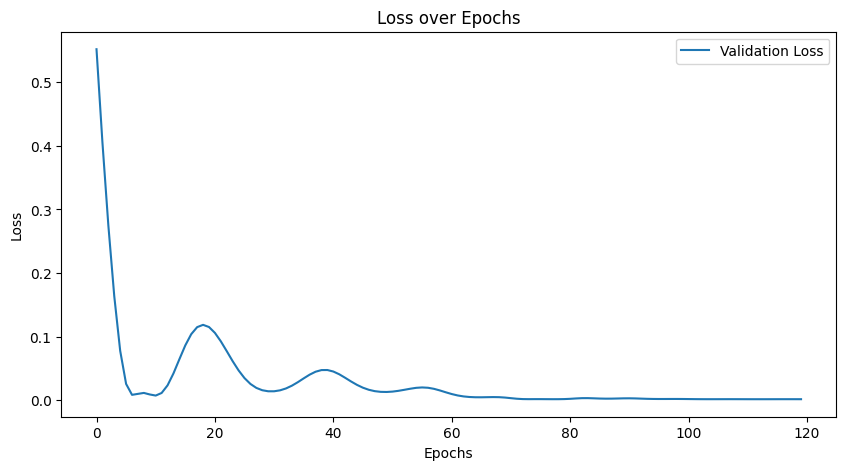

In [6]:
num_epochs = 120
# Define tensors for plotting purposes
train_predictions_epochs = torch.zeros(X_train.shape[0],y_train.shape[1],num_epochs)
test_predictions_epochs = torch.zeros(X_test.shape[0],y_test.shape[1],num_epochs)
# For storing the losses
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    model.eval()
    with torch.no_grad():
        train_predictions_epochs[:,:,epoch] = model(X_train)
        test_predictions_epochs[:,:,epoch] = model(X_test)
    model.train()
    optimizer.zero_grad()


    output = model(X_train)
    loss = criterion(output, y_train)

    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    with torch.no_grad():
        test = model(X_test)
        test_losses.append(criterion(test, y_test).item())
    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
plt.figure(figsize=(10,5))
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


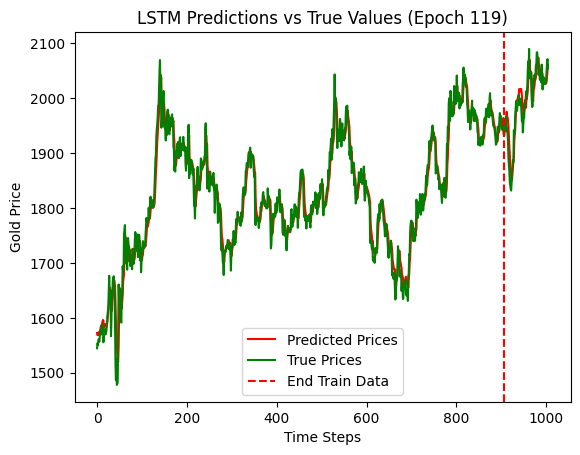

In [7]:
from matplotlib.animation import FuncAnimation
y_hat = torch.cat((train_predictions_epochs,test_predictions_epochs), dim = 0)

# Set up the figure and axis
fig, ax = plt.subplots()
# Setting up the title, labels, and vertical line for end of training data
ax.set_title('LSTM Predictions vs True Values')
ax.set_xlabel('Time Steps')
ax.set_ylabel('Gold Price')
ax.axvline(len(y_train), label='End Train Data', color='red', linestyle='--')
ax.legend()

# Function to update the plot for each frame
def update(frame):
    # Clear the current axis
    ax.clear()

    # Get the jth frame from y_hat
    pred = y_hat[:, :, frame].squeeze()  # Shape [1005]
    true = y.squeeze()  # Shape [1005]

    # Inverse transform using scaler
    pred_numpy = scaler.inverse_transform(pred.numpy().reshape(-1, 1)).flatten()
    true_numpy = scaler.inverse_transform(true.numpy().reshape(-1, 1)).flatten()

    # Plot the predicted and true values
    ax.plot(pred_numpy, label='Predicted Prices', color='red')
    ax.plot(true_numpy, label='True Prices', color='green')
    ax.axvline(len(y_train), label='End Train Data', color='red', linestyle='--')

    # Update the title and labels
    ax.set_title(f'LSTM Predictions vs True Values (Epoch {frame})')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Gold Price')
    ax.legend()
    return ax,

# Create animation
anim = FuncAnimation(fig, update, frames=y_hat.shape[2])

# Save the animation as a GIF
anim.save('lstm_predictions.gif', writer='pillow', fps=5)

plt.show()

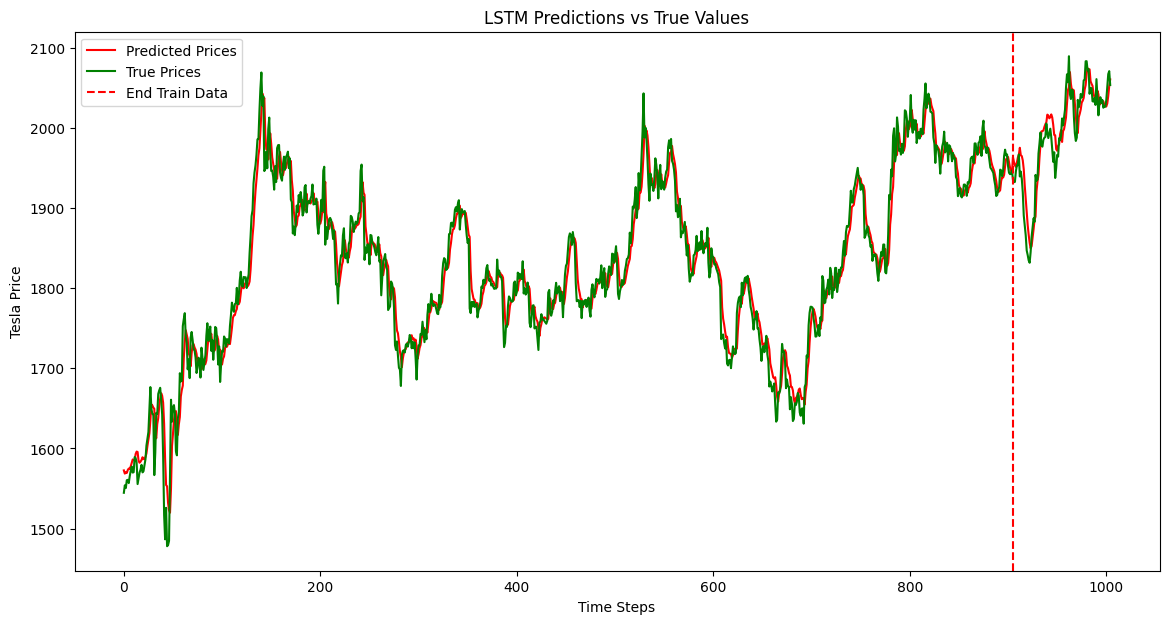

In [8]:
pred = y_hat[:, :, -1].squeeze()  # Shape [1005]
true = y.squeeze()  # Shape [1005]
pred_numpy = scaler.inverse_transform(pred.numpy().reshape(-1, 1)).flatten()
true_numpy = scaler.inverse_transform(true.numpy().reshape(-1, 1)).flatten()

plt.figure(figsize=(14, 7))
# Plot the predicted and true values
plt.plot(pred_numpy, label='Predicted Prices', color='red')
plt.plot(true_numpy, label='True Prices', color='green')
plt.axvline(len(y_train), label='End Train Data', color='red', linestyle='--')
plt.legend()
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Time Steps')
plt.ylabel('Tesla Price')
plt.show()